# MobileNet

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.layers import (Activation, Input, Dense, Conv2D, 
                          MaxPool2D, BatchNormalization, Dropout, 
                          Rescaling, Flatten, DepthwiseConv2D, 
                          AveragePooling2D)
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import L2
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# CONSTANTS

In [3]:
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)
PATH_DATASET_TRAIN = '/mnt/files/Datasets/cats-dogs/training_set/'
PATH_DATASET_TEST = '/mnt/files/Datasets/cats-dogs/test_set/'
BATCH_SIZE = 128
LR_INITIAL = 0.01
N_EPOCHS = 90

# DATASET

## train dataset

In [4]:
train_ds = image_dataset_from_directory(directory=PATH_DATASET_TRAIN,
                                        seed=123,
                                        image_size=(WIDTH, HEIGHT),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE)

Found 8000 files belonging to 2 classes.


## validation/test dataset

In [5]:
test_ds = image_dataset_from_directory(directory=PATH_DATASET_TEST,
                                       seed=123,
                                       image_size=(WIDTH, HEIGHT),
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


## Visualization some examples

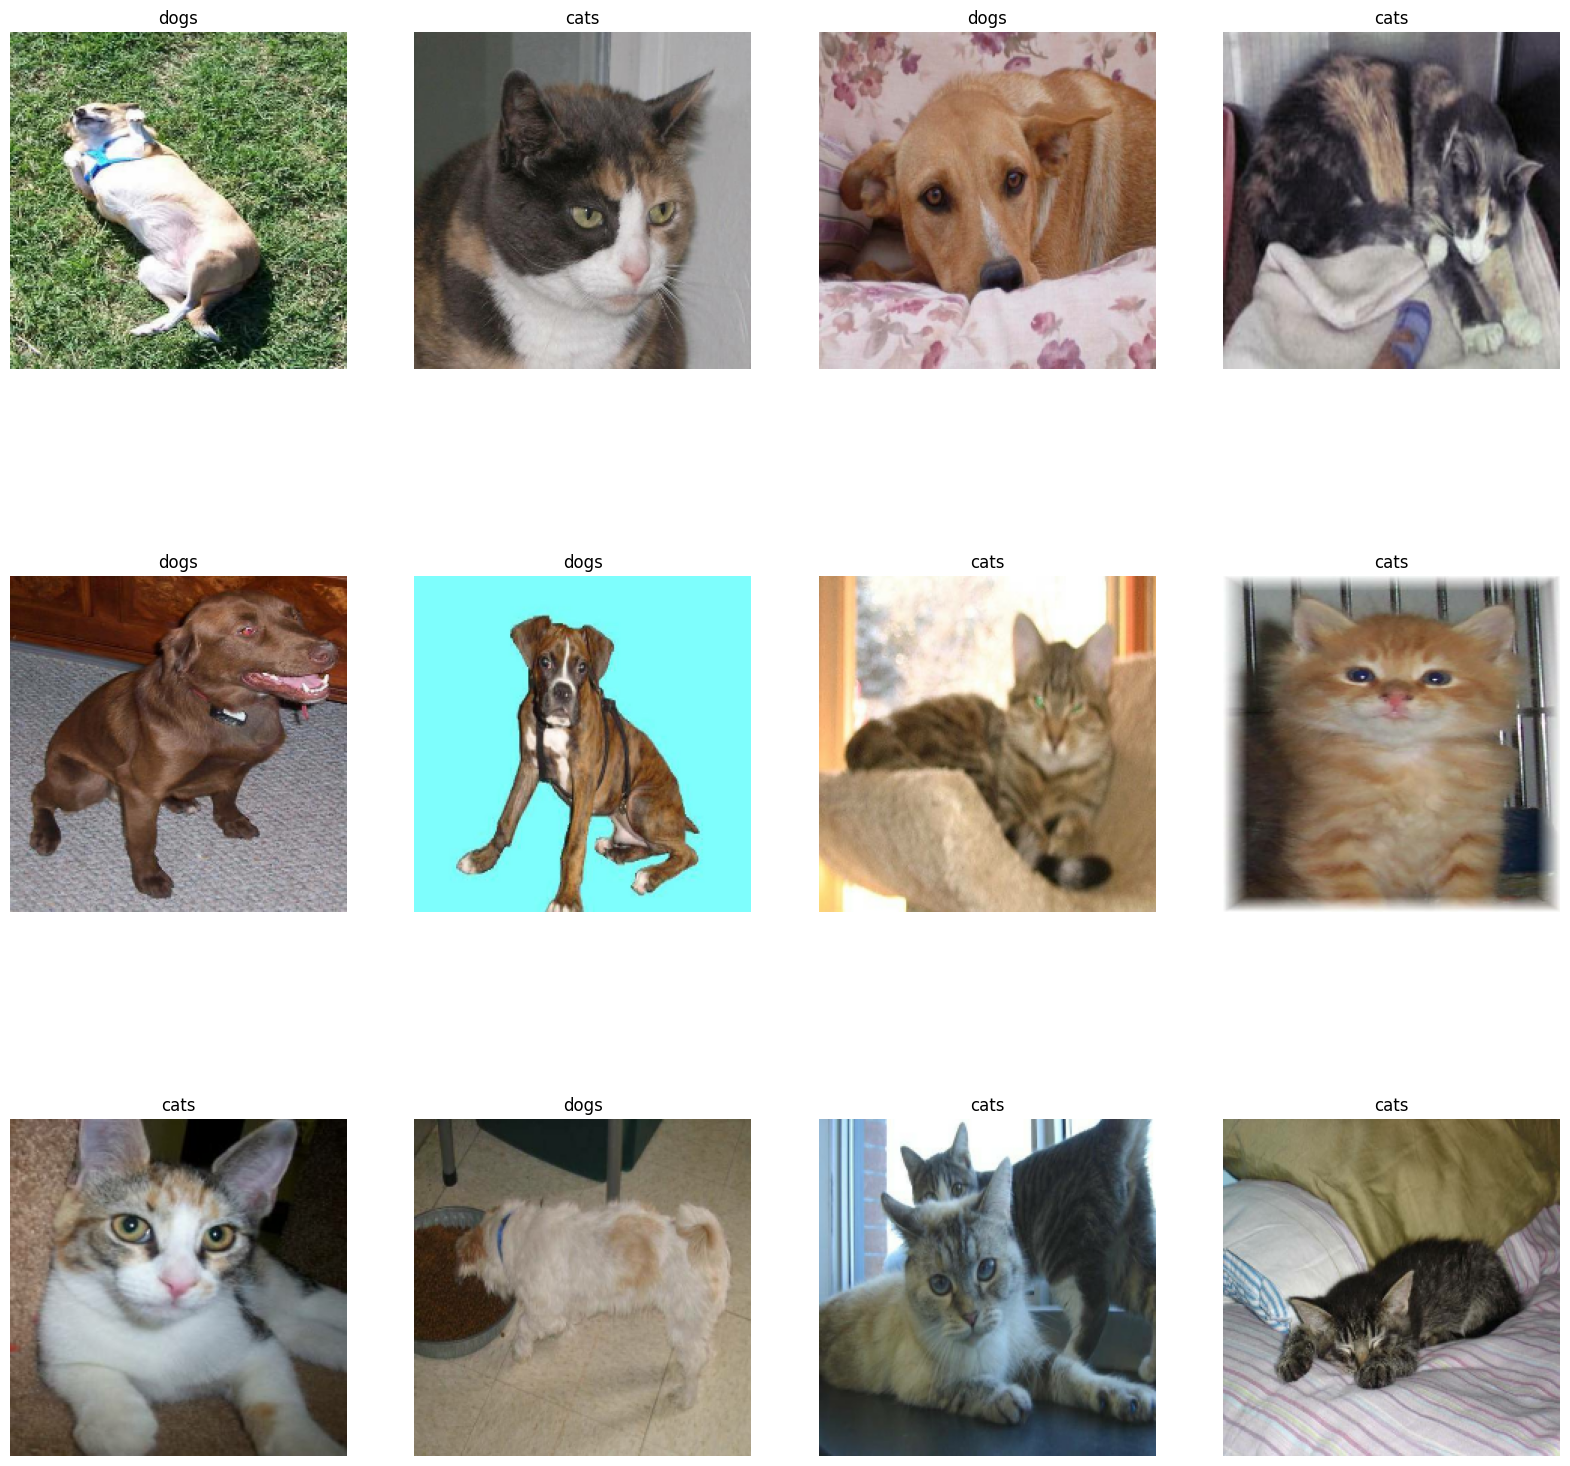

In [7]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# MODEL

In [9]:
def depthwise_pointwise_conv(X, kernel_size, filters, s=1):
    X = DepthwiseConv2D(kernel_size=kernel_size,
                        strides=(s, s),
                        padding='same',
                        activation=None)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=filters,
               kernel_size=(1, 1),
               strides=(1, 1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X
              

In [10]:
def MobileNet(input_shape, classes):
    X_input = Input(input_shape, name='Input Layer')
    X = Rescaling(1./255, offset=0.0)(X_input)
    X = Conv2D(filters=32,
               kernel_size=(3, 3),
               strides=(2, 2),
               activation=None,
               padding='same',
               name='conv1')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Depthwise convolutions 
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=32, s=1)  # Original: 64
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=64, s=2)  # Original: 128
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=64, s=1)  # Original: 128
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=128, s=2)  # Original: 256
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=128, s=1)  # Original: 256
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=256, s=2)  # Original: 256

    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=1)
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=1)
    #X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=1)
    #X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=1)
    #X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=1)

    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=2)  # Original: 1024
    X = depthwise_pointwise_conv(X, kernel_size=(3, 3), filters=512, s=1)  # Original: 1024
    
    X = AveragePooling2D((7, 7))(X)
    
    X = Flatten()(X)
    
    #X = Dense(units=1024, activation='relu')(X)
    #X = Dropout(0.5)(X)
       
    X = Dense(classes, activation='softmax', name=f'fc{classes}')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='MobileNet')
    return model
    

In [11]:
model = MobileNet(input_shape=INPUT_SHAPE, classes=len(class_names))
model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                 

# CALLBACKS

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=8, min_lr=0.5e-6, verbose=1)

checkpoint_filepath = '/tmp/checkpoint/best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

callbacks = [reduce_lr, model_checkpoint_callback]

# OPTIMIZER

In [13]:
optimizer = SGD(learning_rate=LR_INITIAL, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [14]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [15]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, verbose=1)

Epoch 1/90
63/63 [==============================] - 30s 423ms/step - loss: 0.6935 - accuracy: 0.5799 - val_loss: 0.6940 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/90
63/63 [==============================] - 24s 383ms/step - loss: 0.6402 - accuracy: 0.6341 - val_loss: 0.6956 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/90
63/63 [==============================] - 25s 396ms/step - loss: 0.6381 - accuracy: 0.6361 - val_loss: 0.7028 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/90
63/63 [==============================] - 24s 385ms/step - loss: 0.6089 - accuracy: 0.6710 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/90
63/63 [==============================] - 24s 379ms/step - loss: 0.5766 - accuracy: 0.6998 - val_loss: 0.7036 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 6/90
63/63 [==============================] - 25s 393ms/step - loss: 0.5442 - accuracy: 0.7243 - val_loss: 0.7152 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 7/90
63/63 [==============================] - 24s 385ms/st

# EVALUATING

In [16]:
model.load_weights('/tmp/checkpoint/best_model.h5')  # Loading the best model

In [17]:
model.evaluate(test_ds)

16/16 [==============================] - 1s 48ms/step - loss: 0.8025 - accuracy: 0.7680


[0.8024734258651733, 0.7680000066757202]

In [18]:
out = model.evaluate(test_ds)
loss, acc = out[0], out[1]
print(f"loss = {loss:.4f} | acc = {acc:.4f}")

16/16 [==============================] - 1s 48ms/step - loss: 0.8025 - accuracy: 0.7680
loss = 0.8025 | acc = 0.7680


## Curves

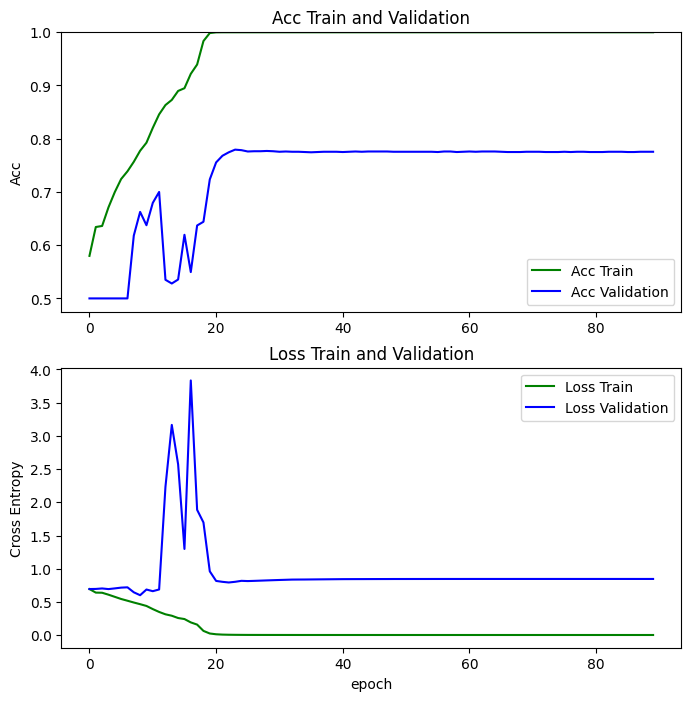

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()

## Infering some examples (green = correct, red = wrong)

4/4 [==============================] - 0s 11ms/step


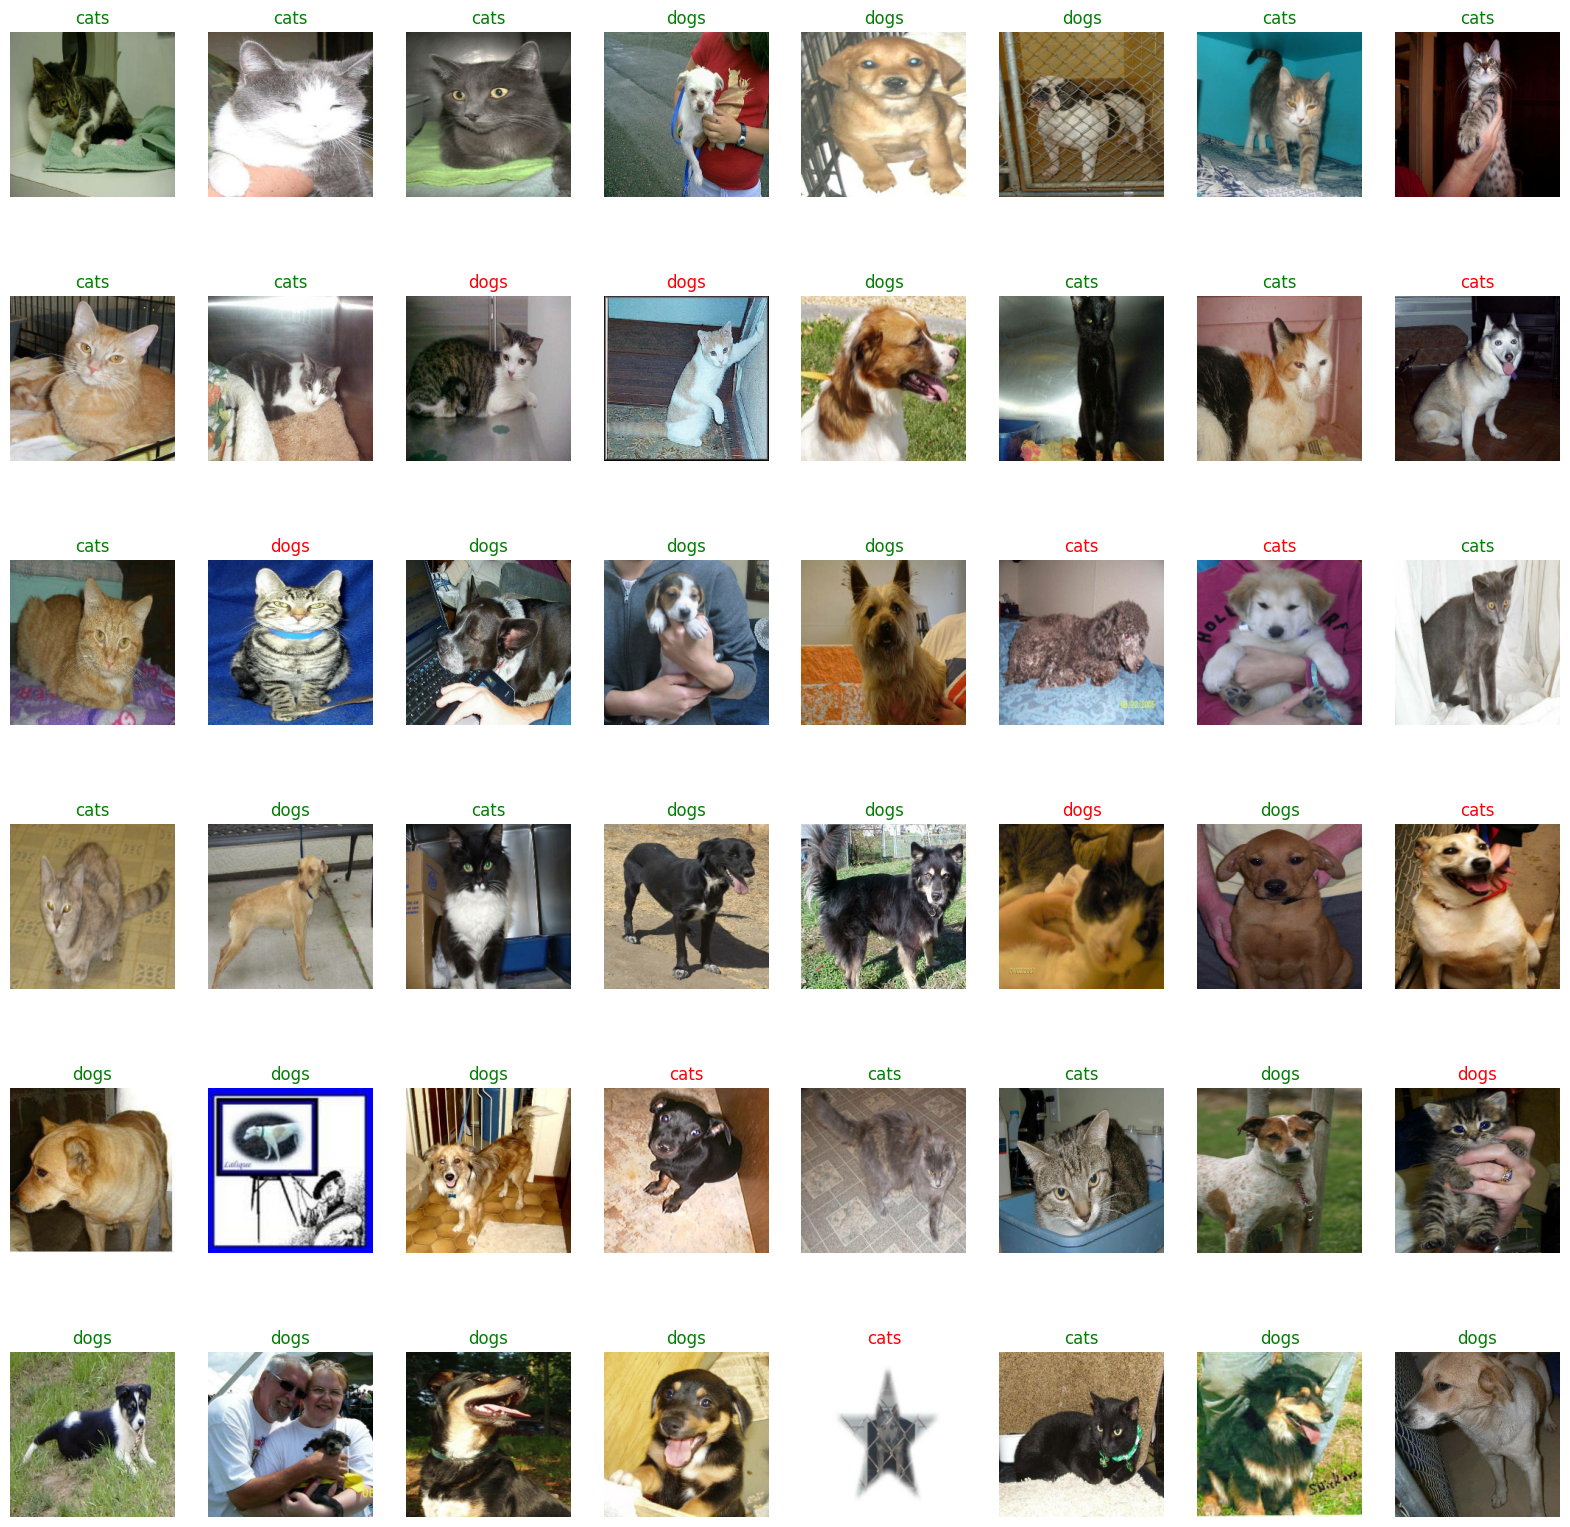

In [20]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    preds_classes = np.argmax(model.predict(images), axis=1)
    
    for i in range(48):
        ax = plt.subplot(6, 8, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if preds_classes[i] == labels[i]:
            plt.title(class_names[preds_classes[i]], color='g')
        else:
            plt.title(class_names[preds_classes[i]], color='r')
        plt.axis('off')